In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
from sklearn import metrics
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from skorch import NeuralNetRegressor, NeuralNetClassifier
import models
from imblearn.over_sampling import RandomOverSampler

df = data_tracks.get_tracks() # note: different Xs can be different shapes
df = data_tracks.remove_invalid_tracks(df)
df = data_tracks.preprocess(df)
df = data_tracks.add_outcome(df)
n = df.shape[0]

# visualize outcomes
- take mean, take sigma, define events with a thtrehold

In [10]:
outcome_score = df['outcome_score'].values
outcome = df['outcome'].values
Y = df['Y'].values

# sort for viz
idxs_sort = np.argsort(outcome_score)
Y_sort = Y[idxs_sort]
outcome_sort = outcome[idxs_sort]

num_pos = np.sum(outcome)
num_neg = n - num_pos
print('n', n, 'num negative', num_neg, 'num positive', num_pos)
# plt.hist(outcome.astype(np.int))
# plt.show()

n 7594 num negative 6254 num positive 1340


**top and bottom**

In [ ]:
R, C = 4, 5
# plt.figure(dpi=200)
plt.figure(figsize=(9, 8))
idxs = list(range(10)) + list(range(n - 10, n))
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    idx = idxs[i]
    plt.plot(Y_sort[idx], color='blue' if outcome_sort[idx] == 0 else 'orange')
#     plt.axis('off')
plt.tight_layout()
plt.savefig('results/worst_best.pdf')

**around the thresh**

In [ ]:
R, C = 8, 10
# plt.figure(dpi=200)
plt.figure(figsize=(18, 12))
idxs = list(range(num_neg - 40, num_neg + 40)) # let's look at ones in the middle
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    idx = idxs[i]
    plt.plot(Y_sort[idx], color='blue' if outcome_sort[idx] == 0 else 'orange')
#     plt.axis('off')
plt.tight_layout()
plt.savefig('results/outcomes_middle.pdf')

# logistic classifier

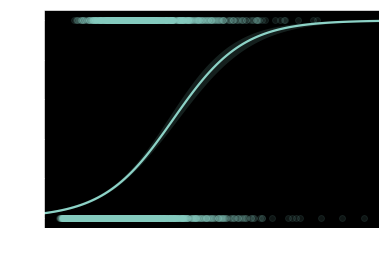

In [2]:
sns.regplot('X_max', 'outcome', df, scatter_kws={'alpha': 0.1}, logistic=True)
plt.savefig('results/logistic.png', dpi=300)

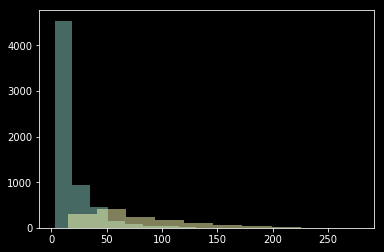

In [20]:
plt.hist(df['lifetime'][df['outcome']==0], alpha=0.5)
plt.hist(df['lifetime'][df['outcome']==1], alpha=0.5)
plt.show()

shapes (4679, 4) (2915, 4)
accuracy        	0.887
precision       	0.876
recall          	0.902
f1              	0.888
balanced_accuracy	0.887
roc_auc         	0.948
X_max	lifetime	total_displacement	mean_square_displacement
[[ 0.62817342  2.49520387  0.29044138 -1.64821504]]


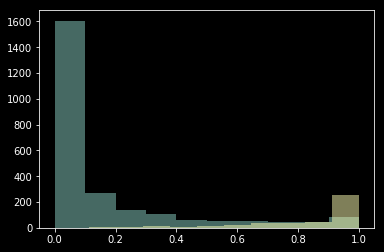

In [29]:
# make logistic data
X = df[['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement']]
X = (X - X.mean()) / X.std()
y = df['outcome'].values


# split training data based on cell num
idxs_train = df.cell_num.isin([1, 2, 3, 4])
idxs_test = ~idxs_train
X_train, Y_train = X[idxs_train], y[idxs_train]
X_test, Y_test = X[idxs_test], y[idxs_test]
# randomly split training data
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('shapes', X_train.shape, X_test.shape)

# resample training data
ros = RandomOverSampler(random_state=42)
X_train_r, Y_train_r = ros.fit_resample(X_train, Y_train)



m = LogisticRegression(solver='lbfgs')
results = cross_validate(m, X_train_r, Y_train_r,  cv=3,
               scoring=['accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc'],
               return_train_score=True, return_estimator=True)
for k in results.keys():
    if 'test' in k:
        print(f'{k.replace("test_", ""):<16}\t{np.mean(results[k]):0.3f}')
# m.score(X_test, Y_test, scoring=['precision'])

m.fit(X_train_r, Y_train_r)
print('X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', sep='\t')
print(m.coef_)
preds = m.predict_proba(X_test)[:, 1]
plt.hist(preds[Y_test==0], alpha=0.5)
plt.hist(preds[Y_test==1], alpha=0.5)
plt.show()

In [ ]:
# mat = deepcopy(X)
# mat['outcome'] = y_outcome
# sns.heatmap(mat.corr(method='pearson'))

# maxconv classifier

In [17]:
# predict using the trace
X_mat = data_tracks.extract_X_mat(df)
X_mat -= np.mean(X_mat)
X_mat /= np.std(X_mat)
outcome = df['outcome'].values.astype(np.int64)
X_train, X_test, Y_train, Y_test = train_test_split(X_mat, outcome, test_size=0.33, random_state=42)
ros = RandomOverSampler(random_state=42)
X_train_r, Y_train_r = ros.fit_resample(X_train, Y_train)

In [ ]:
conv_size = 20
num_channels = 3
dirname = oj('out', f'classification_conv_size={conv_size}_num_channels={num_channels}')

net = NeuralNetClassifier(
    nn.Sequential(models.MaxConv(kernel_size=conv_size, num_units=num_channels), 
                  nn.Linear(1, 2), nn.Softmax()),
    max_epochs=10000,
    lr=1e-3,
    iterator_train__shuffle=True,
    optimizer=torch.optim.SGD,
    callbacks=[Checkpoint(dirname=dirname)],
    device='cpu'
)

net.fit(X_train_r, Y_train_r)

Re-initializing optimizer.


/accounts/projects/vision/.local/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


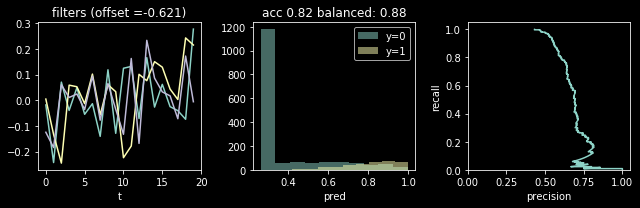

class imbalance 0.18
acc 0.82
roc_auc 0.88
balanced acc: 0.88


In [20]:
# load trained model and plot
net.initialize() # This is important!
net.load_params(
    f_params=oj(dirname, 'params.pt'), f_optimizer=oj(dirname, 'optimizer.pt'), f_history=oj(dirname, 'history.json')
)


R, C = 1, 3
plt.figure(figsize=(3 * C, 3 * R))
ws = net.module_.state_dict()['0.conv1.weight'].cpu().numpy().squeeze()
# print(ws.shape)

plt.subplot(R, C, 1)
plt.title(f'filters (offset ={net.module_.state_dict()["0.offset"].cpu().numpy().squeeze():0.3f})')
plt.plot(ws.T)
plt.xlabel('t')

plt.subplot(R, C, 2)
preds = net.predict_proba(X_test)
preds_labels = net.predict(X_test)
# plt.plot(Y_train, preds[:, 1], 'o', alpha=0.01)
plt.hist(preds[:, 1][Y_test == 0], label='y=0', alpha=0.5)
plt.hist(preds[:, 1][Y_test == 1], label='y=1', alpha=0.5)
plt.title(f'acc {np.mean(Y_test == preds_labels):0.2f} balanced: {metrics.balanced_accuracy_score(Y_test, preds_labels):0.2f}' ) #' r2 {metrics.r2_score(Y_train, preds):0.2f}')
# plt.xlabel('Y')
plt.legend()
plt.xlabel('pred')

plt.subplot(R, C, 3)
precision, recall, thresholds = metrics.precision_recall_curve(Y_test, preds[:, 1])
plt.plot(precision, recall)
plt.xlim((0, 1.05))
plt.ylim((0, 1.05))
plt.xlabel('precision')
plt.ylabel('recall')

plt.tight_layout()
plt.savefig(dirname + '.png')
plt.show()

print(f'class imbalance {np.mean(Y_test):0.2f}')
print(f'acc {np.mean(Y_test == preds_labels):0.2f}')
print(f'roc_auc {metrics.roc_auc_score(Y_test, preds_labels):0.2f}')
print(f'balanced acc: {metrics.balanced_accuracy_score(Y_test, preds_labels):0.2f}') #' r2 {metrics.r2_score(Y_train, preds):0.2f}')